# 東京エレクトロン株価（日足）

In [2]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

symbol = '8035.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-05-13 00:00:00+09:00,34677.988665,35312.100457,33934.888908,34321.300781,4193300,0.0,0.0
2024-05-14 00:00:00+09:00,34370.841689,34707.713588,33964.613811,34271.761719,2421800,0.0,0.0
2024-05-15 00:00:00+09:00,34856.331112,35470.626885,34737.435156,34905.871094,2933300,0.0,0.0
2024-05-16 00:00:00+09:00,36263.266270,36649.678124,35728.234473,36481.242188,4076200,0.0,0.0
2024-05-17 00:00:00+09:00,35817.408919,36104.740830,35470.629026,35757.960938,3125600,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-07 00:00:00+09:00,23605.000000,23670.000000,22595.000000,23055.000000,3888700,0.0,0.0
2024-11-08 00:00:00+09:00,23595.000000,23680.000000,23100.000000,23250.000000,3183100,0.0,0.0
2024-11-11 00:00:00+09:00,22990.000000,23315.000000,22880.000000,23260.000000,2325300,0.0,0.0


## パラボリック SAR

In [3]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

## 日足チャートとパラボリック SAR

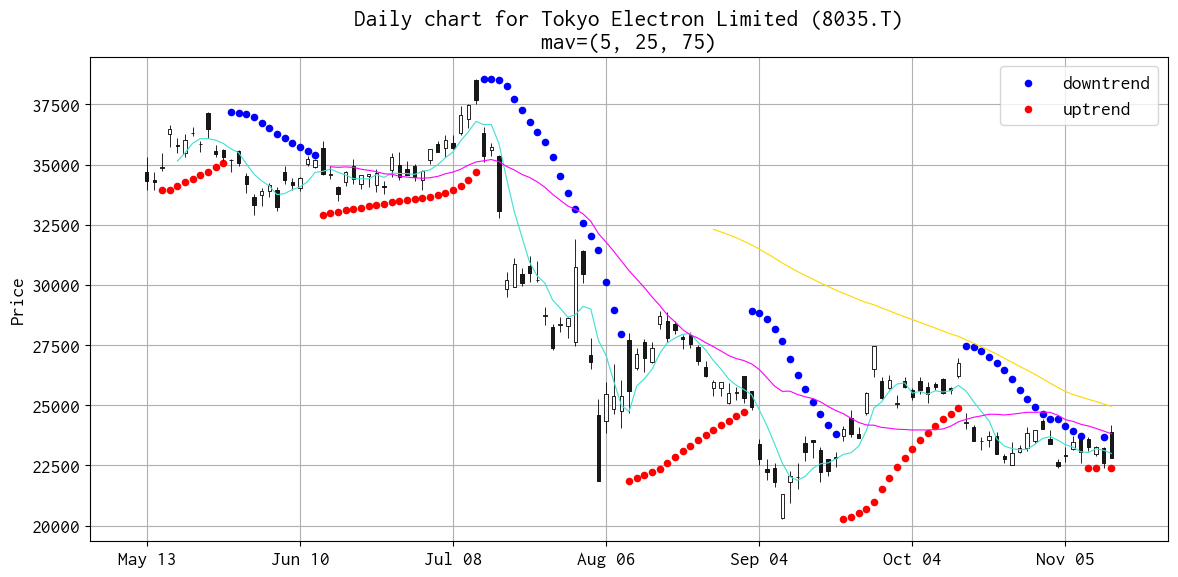

In [15]:
dict_psar = psar(df)

FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 14

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=20,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=20,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    addplot=apds,
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()

plt.tight_layout()
plt.savefig('daily_chart_8035.png')
plt.show()

In [16]:
df.tail(2)['Close']

Date
2024-11-12 00:00:00+09:00    22605.0
2024-11-13 00:00:00+09:00    22805.0
Name: Close, dtype: float64

In [17]:
df.tail(2)['Close'].diff()

Date
2024-11-12 00:00:00+09:00      NaN
2024-11-13 00:00:00+09:00    200.0
Name: Close, dtype: float64

## 東京エレクトロン（後場）

In [12]:
df2 = ticker.history(period='1d', interval='1m')
dt_noon = pd.to_datetime('%s 12:00:00+09:00' % str(df2.index[0].date()))
print(dt_noon)
df2[df2.index > dt_noon]

2024-11-13 12:00:00+09:00


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2024-11-13 12:30:00+09:00,23340.0,23445.0,23330.0,23420.0,5476100,0.0,0.0
2024-11-13 12:31:00+09:00,23420.0,23425.0,23380.0,23385.0,17300,0.0,0.0
2024-11-13 12:32:00+09:00,23375.0,23440.0,23365.0,23430.0,21300,0.0,0.0
2024-11-13 12:33:00+09:00,23430.0,23475.0,23410.0,23460.0,28400,0.0,0.0
2024-11-13 12:34:00+09:00,23455.0,23480.0,23440.0,23440.0,18000,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-13 14:55:00+09:00,22845.0,22850.0,22810.0,22835.0,20600,0.0,0.0
2024-11-13 14:56:00+09:00,22835.0,22865.0,22835.0,22855.0,20900,0.0,0.0
2024-11-13 14:57:00+09:00,22855.0,22900.0,22850.0,22885.0,14200,0.0,0.0


# Tokyo Electron Limited (ADR)

In [13]:
symbol1 = 'TOELY'
ticker1 = yf.Ticker(symbol1)

df1 = ticker1.history(period='6mo')
df1

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-05-14 00:00:00-04:00,110.309998,112.180000,110.309998,112.029999,36100,0.0,0.0
2024-05-15 00:00:00-04:00,114.500000,116.000000,112.000000,115.720001,51300,0.0,0.0
2024-05-16 00:00:00-04:00,120.349998,120.349998,116.889999,117.279999,61900,0.0,0.0
2024-05-17 00:00:00-04:00,117.279999,117.279999,114.889999,115.180000,54800,0.0,0.0
2024-05-20 00:00:00-04:00,117.029999,118.650002,116.720001,118.349998,34300,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-07 00:00:00-05:00,75.000000,76.449997,75.000000,76.449997,117300,0.0,0.0
2024-11-08 00:00:00-05:00,73.320000,76.190002,73.320000,75.089996,107900,0.0,0.0
2024-11-11 00:00:00-05:00,76.529999,76.669998,74.019997,74.019997,214500,0.0,0.0


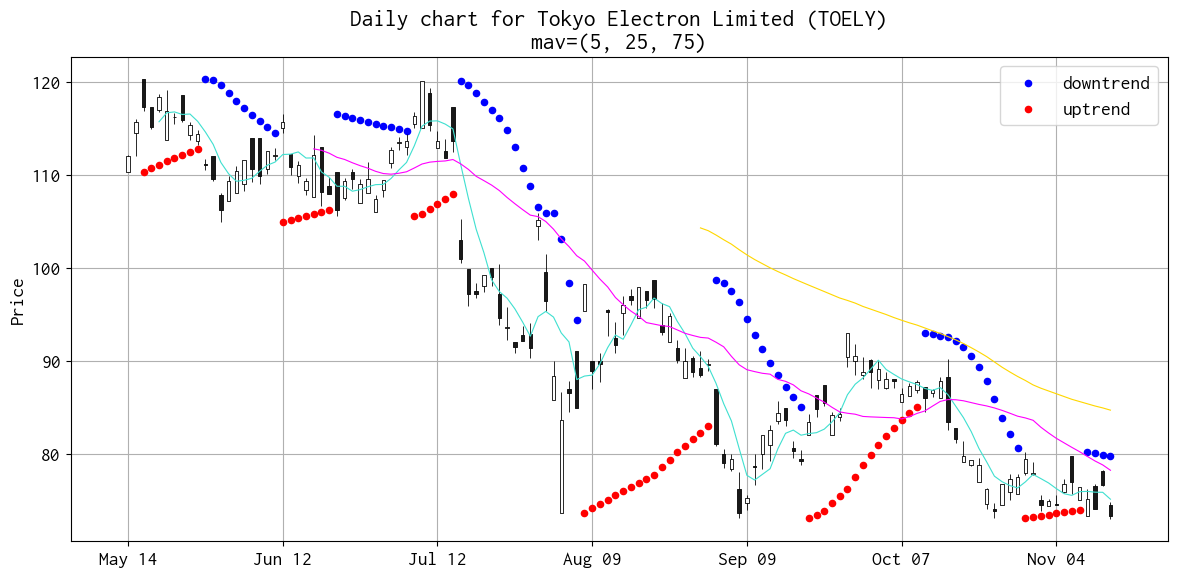

In [14]:
dict_psar = psar(df1)

FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 14

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=20,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=20,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df1,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    addplot=apds,
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker1.info['longName'], symbol1))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol1)

ax.grid()

plt.tight_layout()
plt.savefig('daily_chart_toely.png')
plt.show()